In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from CARTO.Decoder import config
from CARTO.Decoder import utils
from CARTO.Decoder.models import SDF_decoder, backward
from CARTO.Decoder.visualizing import offscreen, code_vis
from CARTO.Decoder.data import dataset
from CARTO.Decoder.multi_poly import MultiPoly
from CARTO.Decoder.eval.reconstruction import (
    ReconstructionConfig,
    ObjectEvalResult,
    CodesEvalResult,
)

# from CARTO.simnet.lib.datasets import PartNetMobilityV0DB
import numpy as np
import skimage
import trimesh
import pyrender
import open3d as o3d
import matplotlib.pyplot as plt
import pathlib
from CARTO.Decoder import loss

# from CARTO.simnet.lib import color_stuff
from CARTO.lib.partnet_mobility import PartNetMobilityV0DB
from sklearn.cluster import KMeans, DBSCAN
from scipy import spatial
import pytorch3d
import tyro
import tqdm
import dataclasses

from typing import List, Dict

import torch
import seaborn as sns

sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


CRITICAL:root:No module named 'asdf'
Traceback (most recent call last):
  File "/home/nickheppert/projects/CARTO/CARTO/Decoder/data/asdf_dataset.py", line 19, in <module>
    from asdf.data import SDFSamples
ModuleNotFoundError: No module named 'asdf'


# Load Results

In [10]:
DECODER_TRAINING_ID = "506fd5f4-ff54-4413-8e13-6f066f182dfb"

local_dir = config.BASE_DIR / "runs" / DECODER_TRAINING_ID
arti_cfg = utils.load_cfg(local_dir)

result_path_base = local_dir / "eval" / "reconstruction"

reconstructions_runs = []
for reconstructions_run in list(result_path_base.glob("*/")):
    result_path_local = result_path_base / reconstructions_run.stem
    if len(list(result_path_local.glob("*"))) <= 1:
        continue

    reconstructions_runs.append(reconstructions_run)

RECONSTRUCTION_ID = None
if RECONSTRUCTION_ID:
    result_path = result_path_base / RECONSTRUCTION_ID
elif len(reconstructions_runs) > 1:
    print(
        f"Pick from: {[path.stem for path in reconstructions_runs]} and set RECONSTRUCTION_ID"
    )
else:
    result_path = reconstructions_runs[0]
result_files = [file_ for file_ in result_path.glob("*") if file_.stem != "config"]
reconstruction_config = utils.load_cfg(result_path, cfg_class=ReconstructionConfig)

In [11]:
all_eval_results = []
for result_file in tqdm.tqdm(result_files):
    with open(result_file, "r") as f:
        results = tyro.from_yaml(ObjectEvalResult, f.read())
    all_eval_results.append(results)

 71%|███████▏  | 67/94 [00:00<00:00, 166.89it/s]

100%|██████████| 94/94 [00:00<00:00, 164.48it/s]


# All Instances

In [12]:
def get_eval_class(eval_result) -> CodesEvalResult:
    return getattr(eval_result, "original_codes")
    # return getattr(eval_result, "reeval_joint_code")
    # return getattr(eval_result, "reprojected_shape_code")


all_cds = np.array([])
all_cds_proj = np.array([])
all_pred_joint_type = np.array([])
all_joint_state_errors = np.array([])
all_correct_joint_types = np.array([])
all_categories = np.array([])
for full_eval_result in all_eval_results:
    eval_result = get_eval_class(full_eval_result)
    all_cds = np.append(all_cds, eval_result.chamfer)
    all_cds_proj = np.append(all_cds_proj, eval_result.chamfer_proj)
    all_pred_joint_type = np.append(all_pred_joint_type, eval_result.pred_joint_type)
    all_joint_state_errors = np.append(all_joint_state_errors, eval_result.joint_error)
    all_correct_joint_types = np.append(
        all_correct_joint_types, eval_result.joint_type_correct
    )
    if arti_cfg.dataset == config.DatasetChoice.ours:
        category = PartNetMobilityV0DB.get_object_meta(full_eval_result.object_id)[
            "model_cat"
        ]
    elif arti_cfg.dataset == config.DatasetChoice.asdf:
        category = full_eval_result.object_id.split("_")[0]
    all_categories = np.append(all_categories, category)

print(f"Chamfer Distance: {(all_cds.mean() * 1000):.3f}")
print(f"Chamfer Distance (Proj): {(all_cds_proj.mean() * 1000):.3f}")
print(f"Chamfer Distance (Proj) (Median): {(np.median(all_cds_proj) * 1000):.3f}")
all_revolute_errors = all_joint_state_errors[
    np.logical_and(all_correct_joint_types, all_pred_joint_type == "revolute")
]
all_prismatic_errors = all_joint_state_errors[
    np.logical_and(all_correct_joint_types, all_pred_joint_type == "prismatic")
]
print(
    f"Joint State Error [revolute]: {(all_revolute_errors.mean()):.5f}rad, {(all_revolute_errors.mean() * 180 / np.pi):.3f}deg"
)
print(f"Joint State Error [prismatic]: {(all_prismatic_errors.mean()):.5f}m")
print(
    f"Joint Type Acc: {(np.count_nonzero(all_correct_joint_types) / len(all_correct_joint_types)):.3f}"
)

## 5deg/10deg
if len(all_revolute_errors) > 0:
    print(
        np.count_nonzero(all_revolute_errors < 5 * np.pi / 180)
        / len(all_revolute_errors)
    )
    print(
        np.count_nonzero(all_revolute_errors < 10 * np.pi / 180)
        / len(all_revolute_errors)
    )
## 5cm/10cm
if len(all_prismatic_errors) > 0:
    print(np.count_nonzero(all_prismatic_errors < 0.05) / len(all_prismatic_errors))
    print(np.count_nonzero(all_prismatic_errors < 0.10) / len(all_prismatic_errors))

Chamfer Distance: 0.673
Chamfer Distance (Proj): 0.623
Chamfer Distance (Proj) (Median): 0.459
Joint State Error [revolute]: 0.16214rad, 9.290deg
Joint State Error [prismatic]: nanm
Joint Type Acc: 0.979
0.4673913043478261
0.6739130434782609


/tmp/ipykernel_3318937/1045666545.py:42: RuntimeWarning: Mean of empty slice.
  print(f"Joint State Error [prismatic]: {(all_prismatic_errors.mean()):.5f}m")
/home/nickheppert/miniconda3/envs/CARTO/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Category-Level

=== Dishwasher samples: 94 ===
CD	0.6728622247464955
CD STD	0.45997337256534315
CD Median	0.5097451794426888
CD (Proj)	0.623096320889593
CD STD (Proj)	0.4523643877337863
CD Median (Proj) 0.4590117314364761
Correct JT	0.9787234042553191
Rev Joint State	9.290136213742567
Rev Joint State STD	10.36720866461659
Rev Joint State Median	5.399505303063323
One Line: Dishwasher	0.6728622247464955	0.623096320889593	9.290136213742567	-	0.9787234042553191
94
Dishwasher	0.6728622247464955	0.623096320889593	9.290136213742567	-	0.9787234042553191


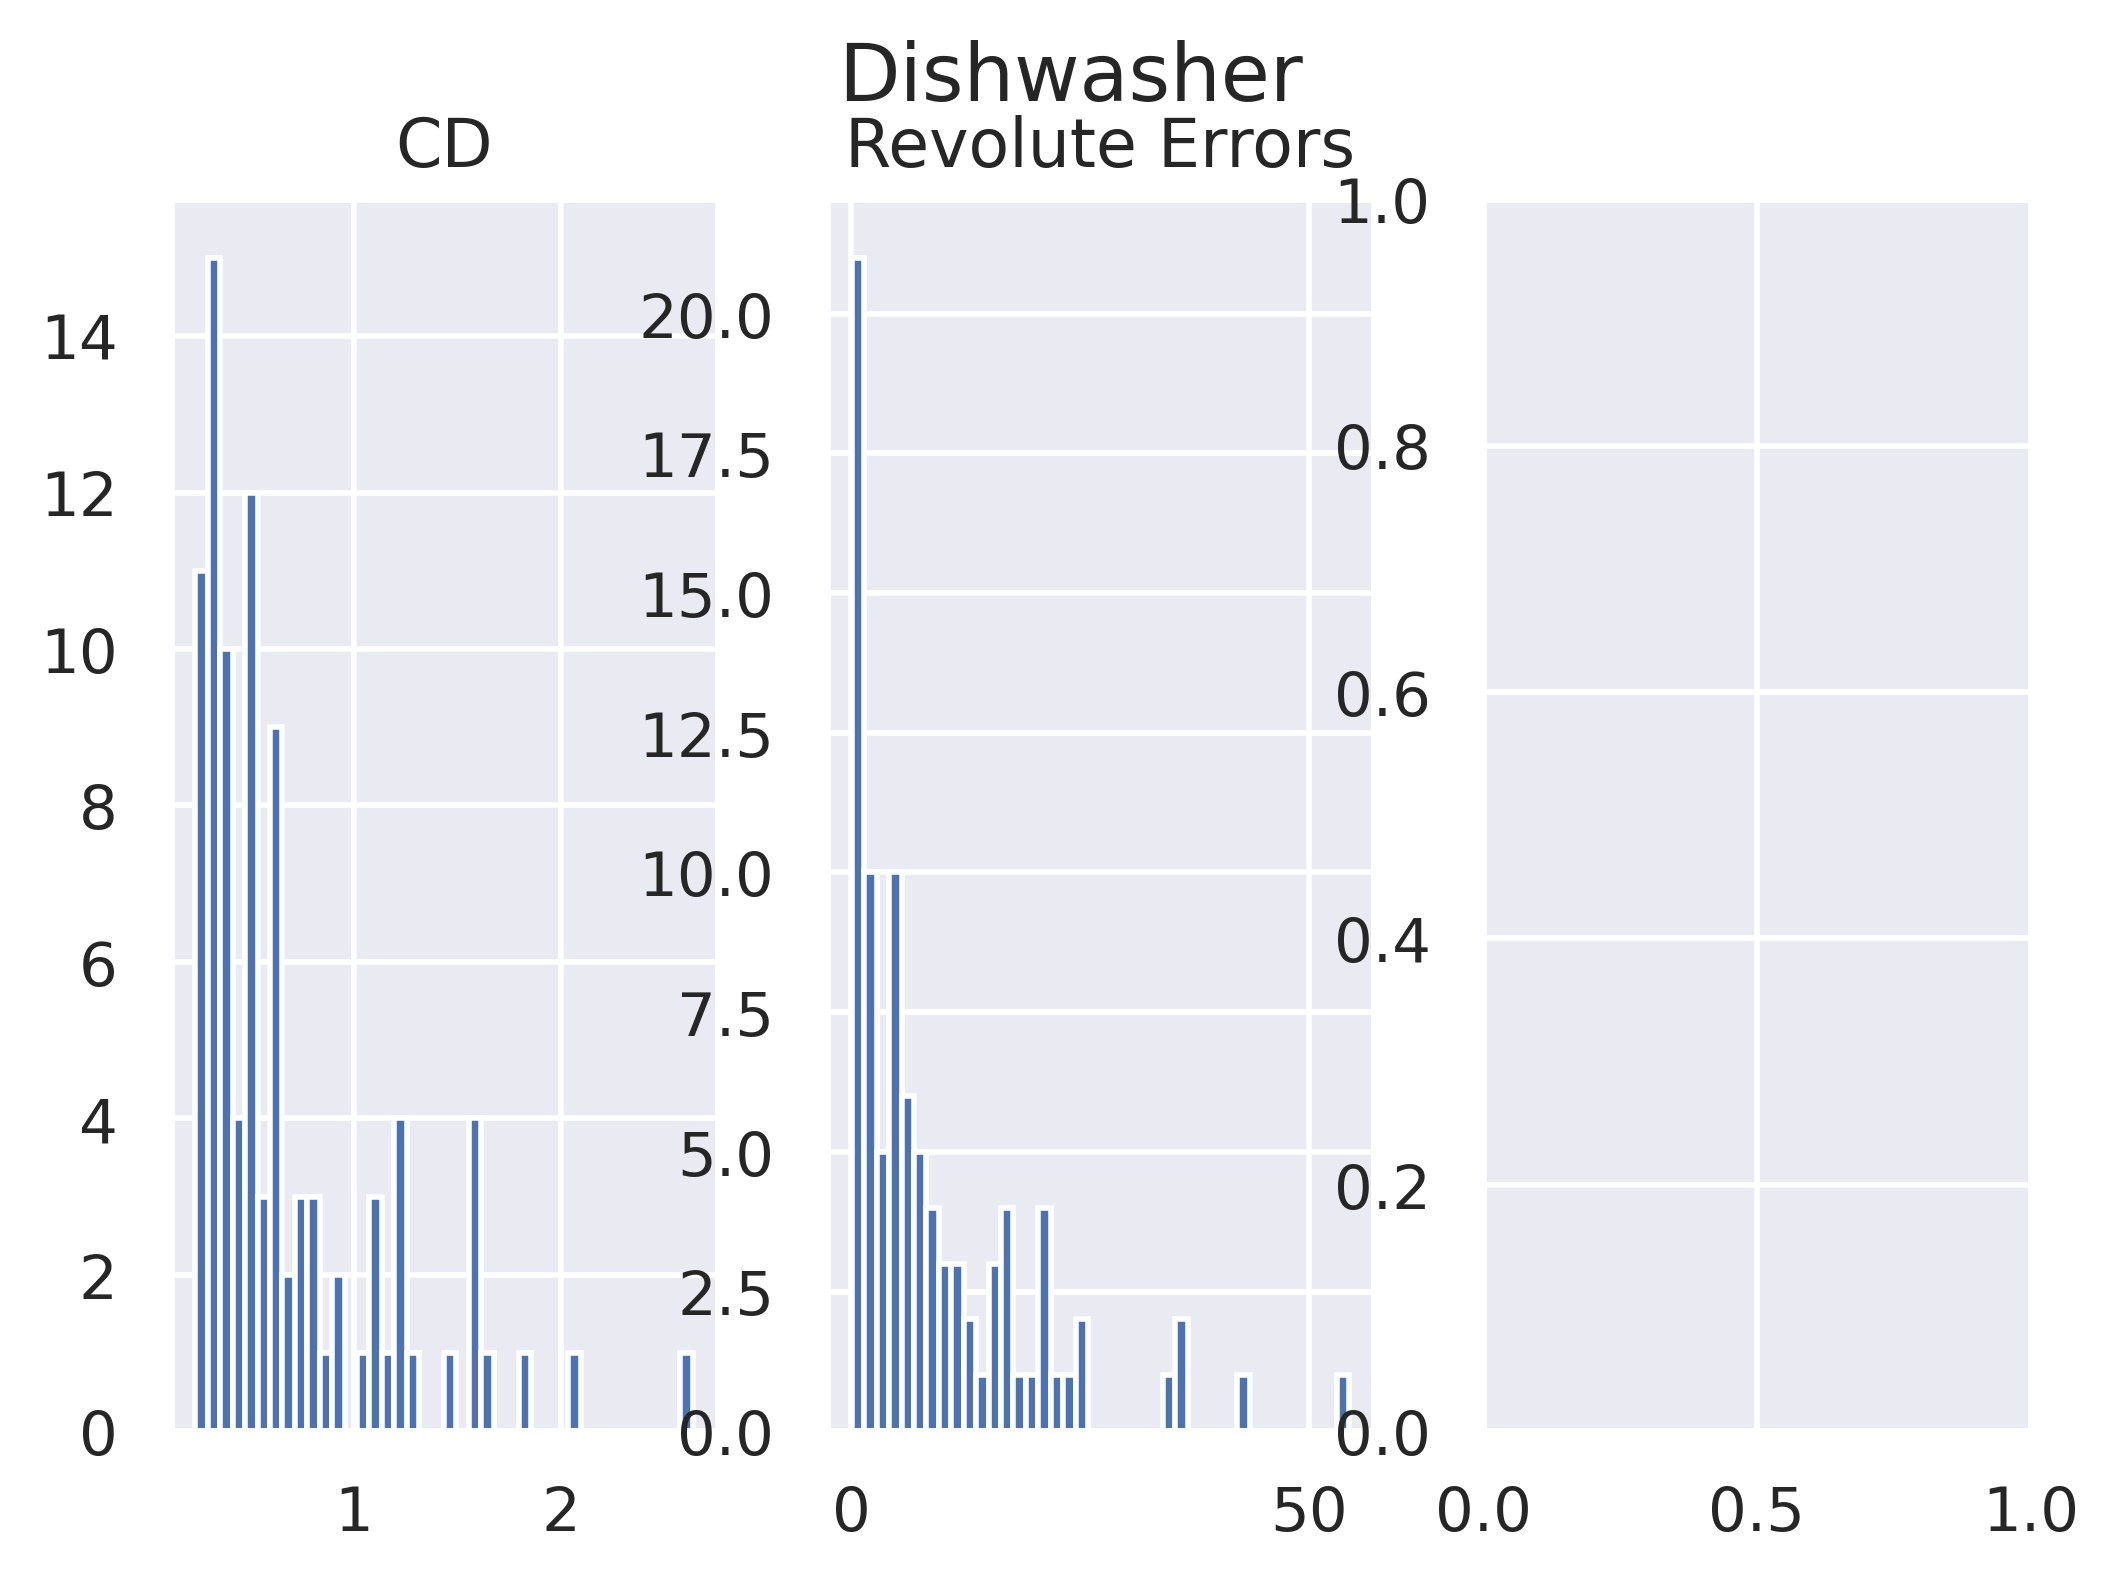

In [13]:
bins = 40

one_lines = []
one_lines_full = []

all_N = 0

for category in sorted(set(all_categories)):
    category_mask = np.array(all_categories) == category
    N = len(all_cds[category_mask])
    all_N += N
    print(f"=== {category} samples: {N} ===")
    fig, axs = plt.subplots(ncols=3, figsize=(6, 4), dpi=400)
    fig.suptitle(f"{category}")
    axs[0].hist(all_cds[category_mask] * 1000, bins=bins)
    axs[0].set_title("CD")
    print(f"CD\t{all_cds[category_mask].mean()*1000}")
    print(f"CD STD\t{all_cds[category_mask].std()*1000}")
    print(f"CD Median\t{np.median(all_cds[category_mask])*1000}")

    print(f"CD (Proj)\t{all_cds_proj[category_mask].mean()*1000}")
    print(f"CD STD (Proj)\t{all_cds_proj[category_mask].std()*1000}")
    print(f"CD Median (Proj) {np.median(all_cds_proj[category_mask])*1000}")

    correct_jt = np.count_nonzero(all_correct_joint_types[category_mask]) / N
    print(f"Correct JT\t{correct_jt}")

    revolute_errors = all_joint_state_errors[
        np.all(
            [all_correct_joint_types, all_pred_joint_type == "revolute", category_mask],
            axis=0,
        )
    ]
    if len(revolute_errors) > 0:
        revolute_errors = revolute_errors * 180 / np.pi
        axs[1].hist(revolute_errors, bins=bins)
        axs[1].set_title("Revolute Errors")
        print(f"Rev Joint State\t{revolute_errors.mean()}")
        print(f"Rev Joint State STD\t{revolute_errors.std()}")
        print(f"Rev Joint State Median\t{np.median(revolute_errors)}")
        revolute_errors = revolute_errors.mean()
    else:
        revolute_errors = "-"

    prismatic_errors = all_joint_state_errors[
        np.all(
            [
                all_correct_joint_types,
                all_pred_joint_type == "prismatic",
                category_mask,
            ],
            axis=0,
        )
    ]
    if len(prismatic_errors) > 0:
        axs[2].hist(prismatic_errors, bins=bins)
        axs[2].set_title("Prismatic Errors")
        print(f"Pris Joint State\t{prismatic_errors.mean()}")
        print(f"Pris Joint State STD\t{prismatic_errors.std()}")
        print(f"Pris Joint State Median\t{np.median(prismatic_errors)}")
        prismatic_errors = prismatic_errors.mean()
    else:
        prismatic_errors = "-"
    one_line = f"{category}\t{all_cds[category_mask].mean()*1000}\t{all_cds_proj[category_mask].mean()*1000}\t{revolute_errors}\t{prismatic_errors}\t{correct_jt}"
    # one_line_full = f"{category}\t{all_cds[category_mask].mean()*1000}\t{all_cds_mesh[category_mask].mean()*1000}\t{revolute_errors}\t{prismatic_errors}\t{correct_jt}"
    one_lines.append(f"{one_line}")
    print(f"One Line: {one_line}")

print(f"{all_N}")
print("\n".join(one_lines))

# Re-Generate Meshes

In [14]:
(
    decoder,
    joint_state_decoder,
    shape_embedding,
    joint_embedding,
    additional_outputs,
) = utils.load_full_decoder(
    DECODER_TRAINING_ID, additional_outputs={"test_dataset": None, "cfg": None}
)
test_dataset = additional_outputs["test_dataset"]
arti_cfg = additional_outputs["cfg"]

reconstruct_dir = local_dir / "vis" / "recon"

DatasetChoice.ours
S = array([6.5686107 , 4.1675878 , 3.8382232 , 3.362702  , 2.863437  ,
       2.6507514 , 2.2964356 , 2.2625654 , 2.0919855 , 2.0237129 ,
       1.921594  , 1.8096942 , 1.7642995 , 1.6535197 , 1.6381592 ,
       1.5763203 , 1.5650297 , 1.466106  , 1.4363924 , 1.3881068 ,
       1.3439969 , 1.2861332 , 1.2686845 , 1.2028935 , 1.1674927 ,
       1.1340964 , 1.0672671 , 0.99428385, 0.97762   , 0.90279317,
       0.8203493 , 0.77917427], dtype=float32)
S = array([118.53704   ,   9.291283  ,   2.801921  ,   2.1654294 ,
         1.0963266 ,   0.8572624 ,   0.71265227,   0.5916847 ,
         0.53369105,   0.4970821 ,   0.47672355,   0.44273704,
         0.42907718,   0.4191601 ,   0.39452162,   0.36457324],
      dtype=float32)
Decoder(
  (lin0): Linear(in_features=48, out_features=509, bias=True)
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=496, bias=True)
  (lin3): Linear(in_features=512, out_features=509, b

In [15]:
for idx, eval_result in enumerate(all_eval_results):
    cd = eval_result.original_codes.chamfer_proj * 1000
    # if cd < 5.00:
    #   continue

    print(f"{idx = } {cd = }")

    ply_dir = reconstruct_dir / f"{idx:05d}"
    ply_dir.mkdir(parents=True, exist_ok=True)

    shape_code = torch.Tensor(eval_result.shape_code).unsqueeze(0)
    arti_code = torch.Tensor(eval_result.joint_code).unsqueeze(0)

    ply_mesh = decoder.get_ply_meshes(
        shape_code,
        arti_code,
        lod_start=4,
        lod_current=8,
        estimate_normals=False,
        chunk_size=2e5,
        distance_threshold=1e-2,
    )

    o3d.io.write_point_cloud(str(ply_dir / "eval.ply"), ply_mesh[0])

    ply_mesh_gt = o3d.geometry.PointCloud()
    ply_mesh_gt.points = o3d.utility.Vector3dVector(test_dataset[idx].full_pc)
    o3d.io.write_point_cloud(str(ply_dir / "gt.ply"), ply_mesh_gt)

    if idx == 0:
        break

idx = 0 cd = 0.24845649022608995
